In [126]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.transform import resize
import cv2
import os
from sklearn.svm import  SVC
import pickle
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time
import math
import functools

In [127]:
def calcDsit (x,y):
    return math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)   

In [128]:
def lineEq (p1,p2):
    m = (p2[1] - p1[1])/ (p2[0] - p1[0])
    c =  p1[1] - m*p1[0]
    return m,c

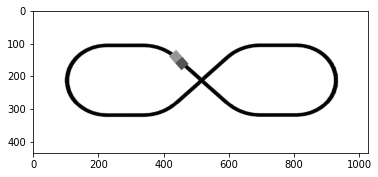

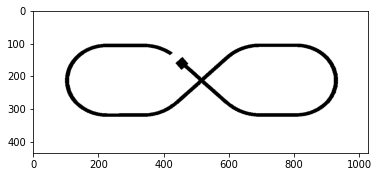

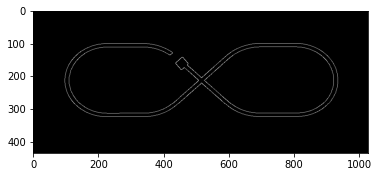

[(211, 323), (352, 323), (215, 110), (352, 110), (387, 107), (548, 247), (451, 145), (598, 277), (680, 99), (821, 99), (682, 312), (817, 312)]


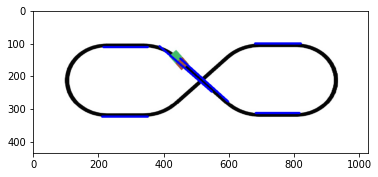

In [144]:
# ################################################################
# Program made to detect lines and from them we can detect curves
# We store the points in order to detect the curves and make the car
# move slowly when it meets a curve
# @ Author Abdelaziz Salah.
################################################################
'''
    Important Notes:
        1. the image starts from the top left corner, so the (0,0) point is the top left corner
        2. we can sort them by using x1, y1, so we get them in order of the most left and upper points.
'''
import cv2
import numpy as np
import functools
import matplotlib.pyplot as plt


def compare(item1, item2):
    '''
        utility function used to sort the lines by the x1 value
        and if they were equal in x, we sort them by y1 value
        in an ascending order
    '''
    if item1[0] < item2[0]:
        return -1
    elif item1[0] > item2[0]:
        return 1
    else:
        if item1[1] < item2[1]:
            return -1
        elif item1[1] > item2[1]:
            return 1
        else:
            return 0


# # Reading the required image in
# # which operations are to be done.
# # Make sure that the image is in the same
# # directory in which this python program is
img = cv2.imread('TrackWithCar.jpg')

# Convert the img to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# applying segmentation

plt.imshow(gray,cmap='gray')
plt.show()

gray[gray < 100] = 0

gray[gray>30] = 1

plt.imshow(gray,cmap='gray')
plt.show()
# gray = cv2.cvtColor(
#     (img * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

# Apply edge detection method on the image
# edges = cv2.Canny(gray, 50, 150, apertureSize=3)
edges = cv2.Canny(gray, 0, 0.1)
plt.imshow(edges,cmap='gray')
plt.show()
# This returns an array of r and theta values
# lines = cv2.HoughLinesP(edges, 1, np.pi/180, 200)

# !Best values. btl3 t2rebn arb3 no2at. 
# lines = cv2.HoughLinesP(
#     edges,  # Input edge image
#     10,  # Distance resolution in pixels
#     np.pi/180,  # Angle resolution in radians
#     threshold=130,  # Min number of votes for valid line
#     minLineLength=120,  # Min allowed length of line -> a2al length l ay line
#     maxLineGap=40  # Max allowed gap between line for joining them -> a2al gab ben el lines to be considered new
# )

lines = cv2.HoughLinesP(
    edges,  # Input edge image
    10,  # Distance resolution in pixels
    np.pi/180,  # Angle resolution in radians
    threshold=130,  # Min number of votes for valid line
    minLineLength=120,  # Min allowed length of line -> a2al length l ay line
    maxLineGap=30  # Max allowed gap between line for joining them -> a2al gab ben el lines to be considered new
)

# Calling
lines = sorted(lines[:, 0], key=functools.cmp_to_key(compare))
TrackPoints =  []

# iterating over each line and draw it.
for points in lines:
    x1, y1, x2, y2 = points
    TrackPoints.append((x1,y1))
    TrackPoints.append((x2,y2))
    # this condition for removing the lines that are not in the track
    if(x1 < 20 or x2 < 20 or x1 > 1150 or x2 > 1150):
        continue
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 250), thickness=5)

print(TrackPoints)
# TODO: now we want to send these points to the car to be able to make it run slowly.
# TODO: and after that it should run fast after it passes the curve.

# All the changes made in the input image are finally
# written on a new image houghlines.jpg
# cv2.imwrite('linesDetected.jpg', img)
plt.imshow(img)
plt.show()

373 424
Curve


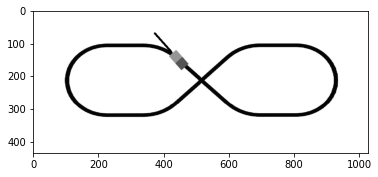

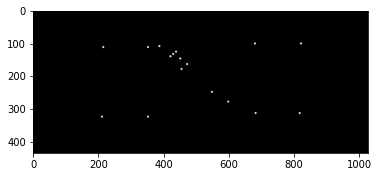

In [145]:
# Read img and convert it to gray scale
img = cv2.imread('TrackWithCar.jpg')
img = img[:,:,:3]
# take copy of img
imggray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# convert to gray scale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)



# Sperate car from background 
# change threshold to sperate correctly
img[( img < 15) | (img>240)] = 0

img[( img > 15) & (img<240)] = 1

# mask that used in erosion
mask = np.array([
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
])

# use erosion to remove thin lines and pixels (errors)
img = binary_erosion(image=img,footprint=mask)

# convert img to float
img = np.float32(img)

# Detect car Corners
corners = cv2.goodFeaturesToTrack(img, 4, 0.1, 20) # parameters(Grayscale image, Maximum number of corners we want,Quality level parameter(preferred value=0.01),Maximum distance between points)

# corners point
points = []

for corner in corners:
    x,y = corner.ravel()
    points.append( np.array([int(x),int(y)]))
    # Draw corner Points
    cv2.circle(img,(int(x),int(y)),3,255,-1)

# This code get the forward point
# the width larger than hight so we get the closed two pairs of points and get midpoint for each pair
# forward point shold have gray scale value higher than the backward point
####################################################################################################
pointPairIndex = []
min1 = calcDsit(points[0],points[1])
min2 = calcDsit(points[0],points[2])
min3 = calcDsit(points[0],points[3])
minmumDistance = 0
if min1 < min2:
    if min1 < min3 :
        pointPairIndex.append([0,1])
        pointPairIndex.append([2,3])
        minmumDistance = min1
    else:
        pointPairIndex.append([0,3])
        pointPairIndex.append([1,2])
        minmumDistance = min3
else:
    if min2 < min3 :
        pointPairIndex.append([0,2])
        pointPairIndex.append([1,3])
        minmumDistance = min2
    else:
        pointPairIndex.append([0,3])
        pointPairIndex.append([1,2])
        minmumDistance = min3
pointPairIndex = np.array(pointPairIndex)
midpoints = []
mid1 = (points[pointPairIndex[0][0]] + points[pointPairIndex[0][1]]) // 2
mid2 = (points[pointPairIndex[1][0]] + points[pointPairIndex[1][1]]) // 2
midpoints = np.array([mid1,mid2])
forwardPoint = 0
if(imggray[midpoints[0][1]][midpoints[0][0]] < imggray[midpoints[1][1]][midpoints[1][0]]):
    forwardPoint = midpoints[1]
else:
    forwardPoint = midpoints[0]
# Draw mid point
cv2.circle(img,(forwardPoint[0],forwardPoint[1]),3,255,-1)
####################################################################################################

# Get line Equation used to detect if line or curve
m , c = lineEq(midpoints[0],midpoints[1])
curve = 0

# this code detect the direction of the car
####################################################################################################
y = ( forwardPoint[0] - (minmumDistance//4)) * m + c
y_range = imggray[int(round(y) - (minmumDistance//6)) : int(round(y) + (minmumDistance//6)) , int(forwardPoint[0] - (minmumDistance//4))]
# el factor da bsta5demo eny 3awz el3arabya tshof 2damha 2ad eh w hya bt7ded ely 2damha line wla curve lw ghyato el5t ely tale3 mn el3rabya hytghyer
factor = 2.5
if ((y_range < 50).astype(bool).any()) :
    minX = forwardPoint[0] - int(minmumDistance * factor) 
    maxX = forwardPoint[0] - 5
else:
    minX = forwardPoint[0] + 5
    maxX = forwardPoint[0] + int(minmumDistance * factor)
####################################################################################################

# msh ba5od el y blzabt ba5od range 3lashan el3rabya msh 3la el line blzabt (error) w momkn tghyer el range 
yRange = minmumDistance//4
print( minX , maxX)
for i in range (minX , maxX):
    y = i * m + c
    y_range = imggray[int(round(y) - (yRange)) : int(round(y) + (yRange)) , i]
    # check law mafesh eswd ya3ny el line msh kamel (curve)
    if ~(y_range < 50).astype(bool).any():
        curve = 1
# barsem el line ely 2dam el3rabya msh 2kter
for i in range (minX , maxX):
    y = i * m + c
    cv2.circle(imggray,(i ,int(y)),3,0,-1)

for point in TrackPoints:
    cv2.circle(img,(point[0],point[1]),3,255,-1)

if curve == 1:
    print('Curve')
else:
    print('Straight Line')

plt.imshow(imggray,cmap='gray')
plt.show()
plt.imshow(img,cmap='gray')
plt.show()
